In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTForImageClassification, Trainer, TrainingArguments, TrainerCallback
from PIL import Image
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json

# Custom Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, processor):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        # Process image using ViT processor
        inputs = self.processor(images=image, return_tensors="pt")
        
        return {
            'pixel_values': inputs['pixel_values'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Data preparation function
def prepare_data_splits(data_dir, test_size=0.2, val_size=0.2, random_state=42):
    """
    Prepare train/validation/test splits from the data directory
    """
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    # Collect all image paths and labels from Training directory
    all_image_paths = []
    all_labels = []
    
    train_dir = os.path.join(data_dir, 'Training')
    for class_name in classes:
        class_dir = os.path.join(train_dir, class_name)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_image_paths.append(os.path.join(class_dir, img_file))
                    all_labels.append(class_to_idx[class_name])
    
    # First split: separate test set
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        all_image_paths, all_labels, test_size=test_size, random_state=random_state, stratify=all_labels
    )
    
    # Second split: separate validation from training
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels, test_size=val_size/(1-test_size), 
        random_state=random_state, stratify=train_val_labels
    )
    
    # Also include the original test set if it exists
    test_dir = os.path.join(data_dir, 'Testing')
    if os.path.exists(test_dir):
        for class_name in classes:
            class_dir = os.path.join(test_dir, class_name)
            if os.path.exists(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        test_paths.append(os.path.join(class_dir, img_file))
                        test_labels.append(class_to_idx[class_name])
    
    print(f"Data split summary:")
    print(f"Training samples: {len(train_paths)}")
    print(f"Validation samples: {len(val_paths)}")
    print(f"Test samples: {len(test_paths)}")
    
    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

# Custom callback for plotting metrics and losses
class MetricsPlottingCallback(TrainerCallback):
    def __init__(self, output_dir="./plots"):
        self.output_dir = output_dir
        self.train_losses = []
        self.eval_losses = []
        self.eval_metrics = defaultdict(list)
        self.steps = []
        self.eval_steps = []
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        """Called when logging occurs"""
        if logs is not None:
            # Store training loss
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
                self.steps.append(state.global_step)
            
            # Store evaluation metrics
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
                self.eval_steps.append(state.global_step)
                
                # Store other evaluation metrics
                for key, value in logs.items():
                    if key.startswith('eval_') and key != 'eval_loss':
                        metric_name = key.replace('eval_', '')
                        self.eval_metrics[metric_name].append(value)
    
    def on_train_end(self, args, state, control, **kwargs):
        """Called at the end of training to create final plots"""
        self.plot_metrics()
        self.save_metrics_data()
    
    def plot_metrics(self):
        """Create and save plots for losses and metrics"""
        # Plot training and evaluation losses
        plt.figure(figsize=(15, 10))
        
        # Loss plot
        plt.subplot(2, 2, 1)
        if self.train_losses:
            plt.plot(self.steps, self.train_losses, label='Training Loss', color='blue', alpha=0.7)
        if self.eval_losses and self.eval_steps:
            plt.plot(self.eval_steps, self.eval_losses, label='Validation Loss', color='red', alpha=0.7)
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Accuracy plot
        plt.subplot(2, 2, 2)
        if 'accuracy' in self.eval_metrics:
            plt.plot(self.eval_steps, self.eval_metrics['accuracy'], label='Validation Accuracy', color='green')
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # F1 Score plot
        plt.subplot(2, 2, 3)
        if 'f1' in self.eval_metrics:
            plt.plot(self.eval_steps, self.eval_metrics['f1'], label='Validation F1', color='orange')
        plt.xlabel('Steps')
        plt.ylabel('F1 Score')
        plt.title('Validation F1 Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Precision and Recall plot
        plt.subplot(2, 2, 4)
        if 'precision' in self.eval_metrics:
            plt.plot(self.eval_steps, self.eval_metrics['precision'], label='Precision', color='purple')
        if 'recall' in self.eval_metrics:
            plt.plot(self.eval_steps, self.eval_metrics['recall'], label='Recall', color='brown')
        plt.xlabel('Steps')
        plt.ylabel('Score')
        plt.title('Precision and Recall')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'training_metrics.png'), dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Plots saved to {os.path.join(self.output_dir, 'training_metrics.png')}")
    
    def save_metrics_data(self):
        """Save metrics data to JSON file"""
        metrics_data = {
            'train_losses': self.train_losses,
            'train_steps': self.steps,
            'eval_losses': self.eval_losses,
            'eval_steps': self.eval_steps,
            'eval_metrics': dict(self.eval_metrics)
        }
        
        with open(os.path.join(self.output_dir, 'training_metrics.json'), 'w') as f:
            json.dump(metrics_data, f, indent=2)
        
        print(f"Metrics data saved to {os.path.join(self.output_dir, 'training_metrics.json')}")

# Function to generate detailed classification report and confusion matrix
def generate_classification_report(trainer, dataset, class_names, dataset_name="Test", output_dir="./plots"):
    """
    Generate comprehensive classification report with confusion matrix
    """
    # Get predictions
    predictions = trainer.predict(dataset)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=1)
    
    # Create classification report
    report = classification_report(
        y_true, y_pred, 
        target_names=class_names, 
        output_dict=True
    )
    
    # Print classification report
    print(f"\n{'='*60}")
    print(f"{dataset_name.upper()} SET CLASSIFICATION REPORT")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of samples'})
    plt.title(f'{dataset_name} Set - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    
    # Save confusion matrix plot
    cm_path = os.path.join(output_dir, f'{dataset_name.lower()}_confusion_matrix.png')
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create detailed metrics DataFrame
    metrics_df = pd.DataFrame({
        'Class': class_names + ['Overall'],
        'Precision': [report[cls]['precision'] for cls in class_names] + [report['weighted avg']['precision']],
        'Recall': [report[cls]['recall'] for cls in class_names] + [report['weighted avg']['recall']],
        'F1-Score': [report[cls]['f1-score'] for cls in class_names] + [report['weighted avg']['f1-score']],
        'Support': [report[cls]['support'] for cls in class_names] + [report['weighted avg']['support']]
    })
    
    print(f"\n{dataset_name} Set - Detailed Metrics:")
    print(metrics_df.to_string(index=False, float_format='%.4f'))
    
    # Save classification report data
    report_path = os.path.join(output_dir, f'{dataset_name.lower()}_classification_report.json')
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    
    # Save metrics DataFrame
    csv_path = os.path.join(output_dir, f'{dataset_name.lower()}_metrics.csv')
    metrics_df.to_csv(csv_path, index=False)
    
    print(f"\nFiles saved:")
    print(f"- Confusion matrix: {cm_path}")
    print(f"- Classification report: {report_path}")
    print(f"- Metrics CSV: {csv_path}")
    
    return report, cm, metrics_df
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

# Metrics computation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

2025-08-22 20:22:55.434317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755894175.642845      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755894175.699946      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
MODEL_NAME = "google/vit-base-patch16-224-in21k"
DATA_DIR = "/kaggle/input/brain-tumor-mri-dataset"
OUTPUT_DIR = "./vit-brain-tumor-classifier"
PLOTS_DIR = "./plots"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4,  
    id2label={0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'},
    label2id={'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Create datasets

(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = prepare_data_splits(DATA_DIR)
    
train_dataset = BrainTumorDataset(train_paths, train_labels, processor)
val_dataset = BrainTumorDataset(val_paths, val_labels, processor)
test_dataset = BrainTumorDataset(test_paths, test_labels, processor)

Data split summary:
Training samples: 3426
Validation samples: 1143
Test samples: 2454


In [5]:
from huggingface_hub import notebook_login

notebook_login()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting training...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,No log,1.394649,0.308836,0.258056,0.272579,0.308836
20,No log,1.385957,0.349081,0.289133,0.335495,0.349081
30,No log,1.371437,0.398075,0.323771,0.425300,0.398075
40,No log,1.349008,0.492563,0.442236,0.631727,0.492563
50,1.372100,1.307580,0.648294,0.633898,0.710382,0.648294
60,1.372100,1.240494,0.767279,0.758114,0.765437,0.767279
70,1.372100,1.149921,0.813648,0.810438,0.818810,0.813648
80,1.372100,1.046338,0.845144,0.839900,0.844854,0.845144
90,1.372100,0.939118,0.847769,0.841561,0.847289,0.847769
100,1.088000,0.834028,0.876640,0.874851,0.874541,0.876640


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

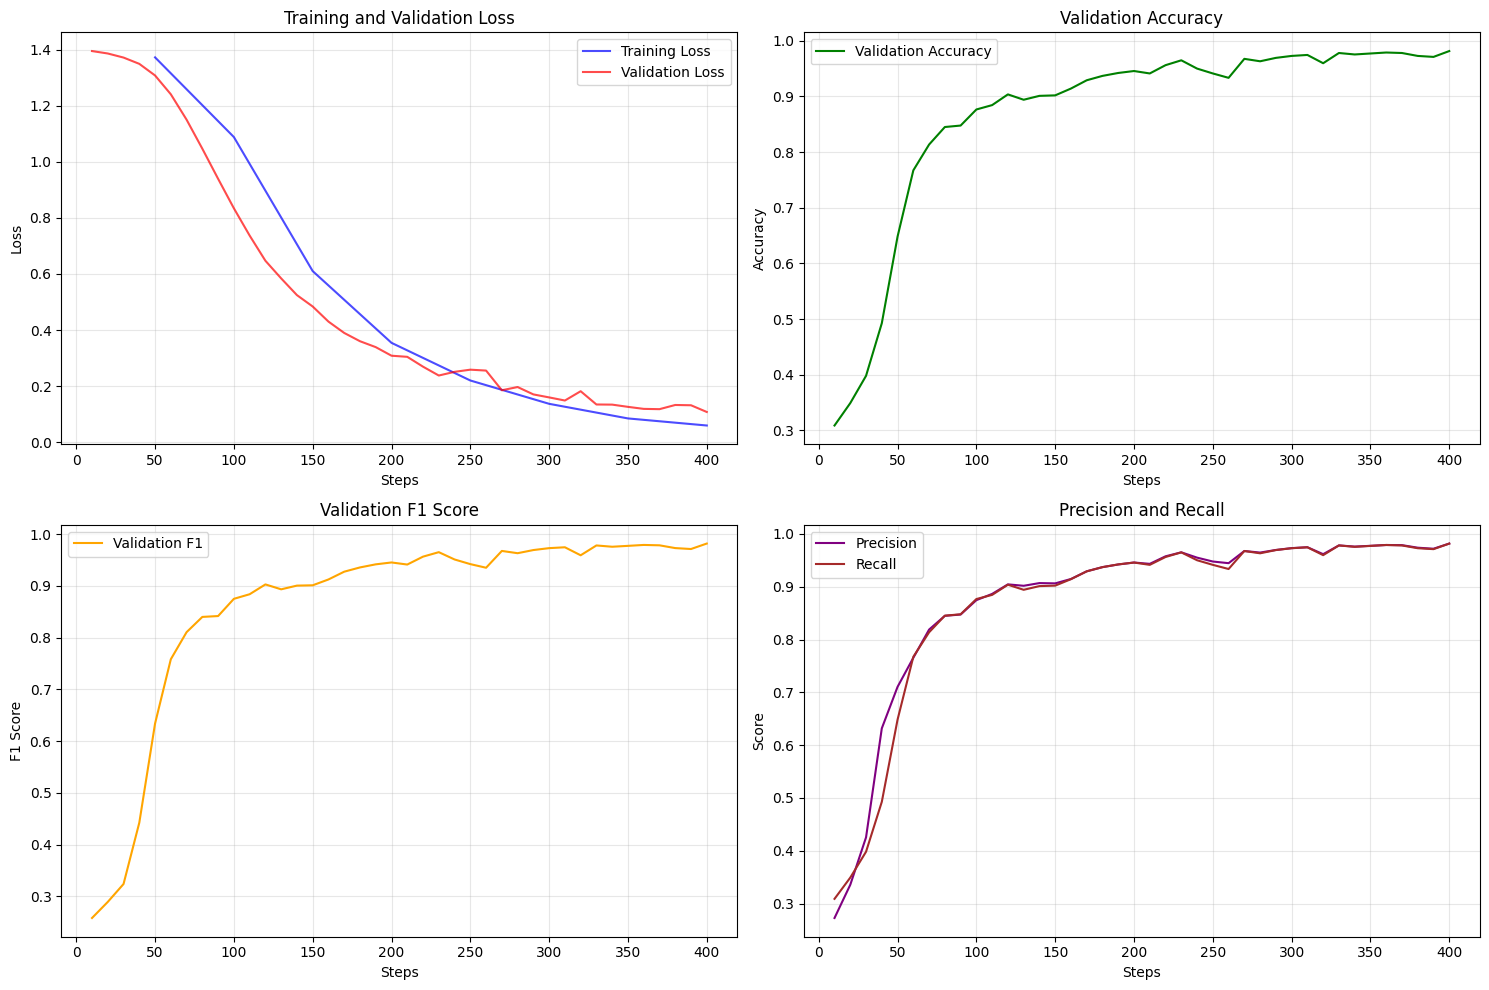

Plots saved to ./plots/training_metrics.png
Metrics data saved to ./plots/training_metrics.json


TrainOutput(global_step=405, training_loss=0.48529449767536587, metrics={'train_runtime': 1946.091, 'train_samples_per_second': 26.407, 'train_steps_per_second': 0.208, 'total_flos': 3.9823847307236966e+18, 'train_loss': 0.48529449767536587, 'epoch': 15.0})

In [7]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=15,
    learning_rate=3e-5,
    warmup_steps=400,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=10,
    save_steps=200,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    push_to_hub=False,  # Set to True if you want to push to hub
    report_to=None,  # Disable wandb reporting
)

# Initialize plotting callback
plotting_callback = MetricsPlottingCallback(output_dir=PLOTS_DIR)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Use validation set for evaluation during training
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[plotting_callback],
)

# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

# Train the model
print("Starting training...")
trainer.train()

Evaluating on validation set...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Validation Results: {'eval_loss': 0.10783480107784271, 'eval_accuracy': 0.9816272965879265, 'eval_f1': 0.9816525019188637, 'eval_precision': 0.9817178465996458, 'eval_recall': 0.9816272965879265, 'eval_runtime': 15.8442, 'eval_samples_per_second': 72.14, 'eval_steps_per_second': 0.568, 'epoch': 15.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



VALIDATION SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma       0.98      0.97      0.98       264
  meningioma       0.96      0.97      0.96       268
     notumor       1.00      0.99      0.99       319
   pituitary       0.98      0.99      0.99       292

    accuracy                           0.98      1143
   macro avg       0.98      0.98      0.98      1143
weighted avg       0.98      0.98      0.98      1143



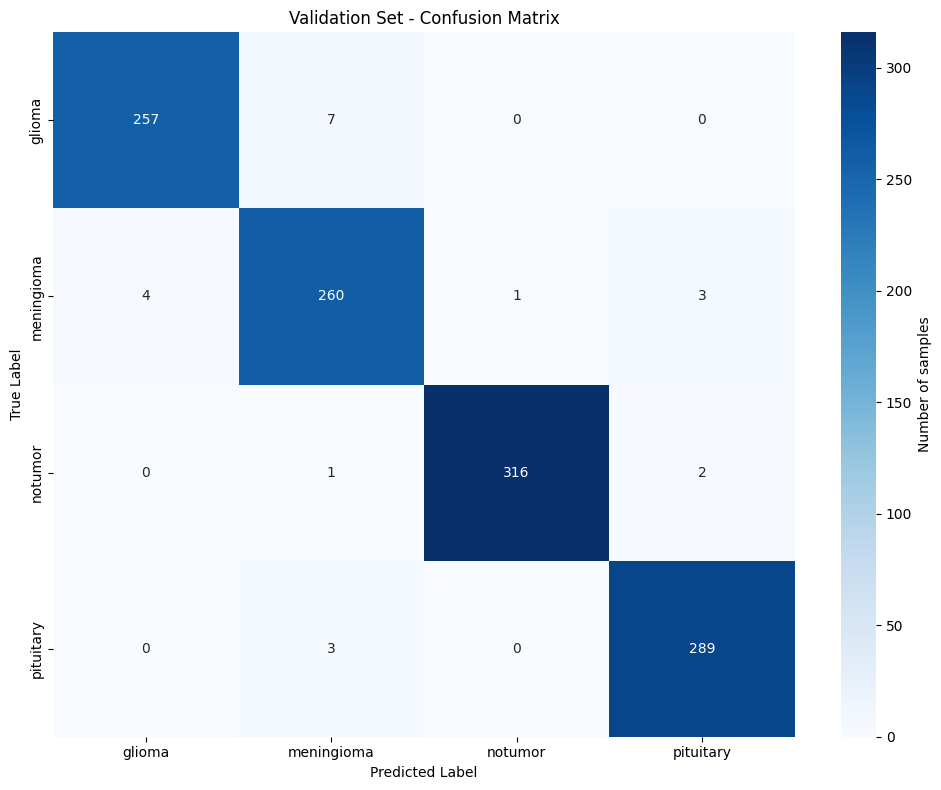


Validation Set - Detailed Metrics:
     Class  Precision  Recall  F1-Score  Support
    glioma     0.9847  0.9735    0.9790      264
meningioma     0.9594  0.9701    0.9647      268
   notumor     0.9968  0.9906    0.9937      319
 pituitary     0.9830  0.9897    0.9863      292
   Overall     0.9817  0.9816    0.9817     1143

Files saved:
- Confusion matrix: ./plots/validation_confusion_matrix.png
- Classification report: ./plots/validation_classification_report.json
- Metrics CSV: ./plots/validation_metrics.csv
Evaluating on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Results: {'eval_loss': 0.09876887500286102, 'eval_accuracy': 0.980440097799511, 'eval_f1': 0.98046352729672, 'eval_precision': 0.9805335391200682, 'eval_recall': 0.980440097799511, 'eval_runtime': 44.4265, 'eval_samples_per_second': 55.237, 'eval_steps_per_second': 0.45, 'epoch': 15.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       564
  meningioma       0.96      0.97      0.96       574
     notumor       0.99      0.99      0.99       724
   pituitary       0.99      0.98      0.98       592

    accuracy                           0.98      2454
   macro avg       0.98      0.98      0.98      2454
weighted avg       0.98      0.98      0.98      2454



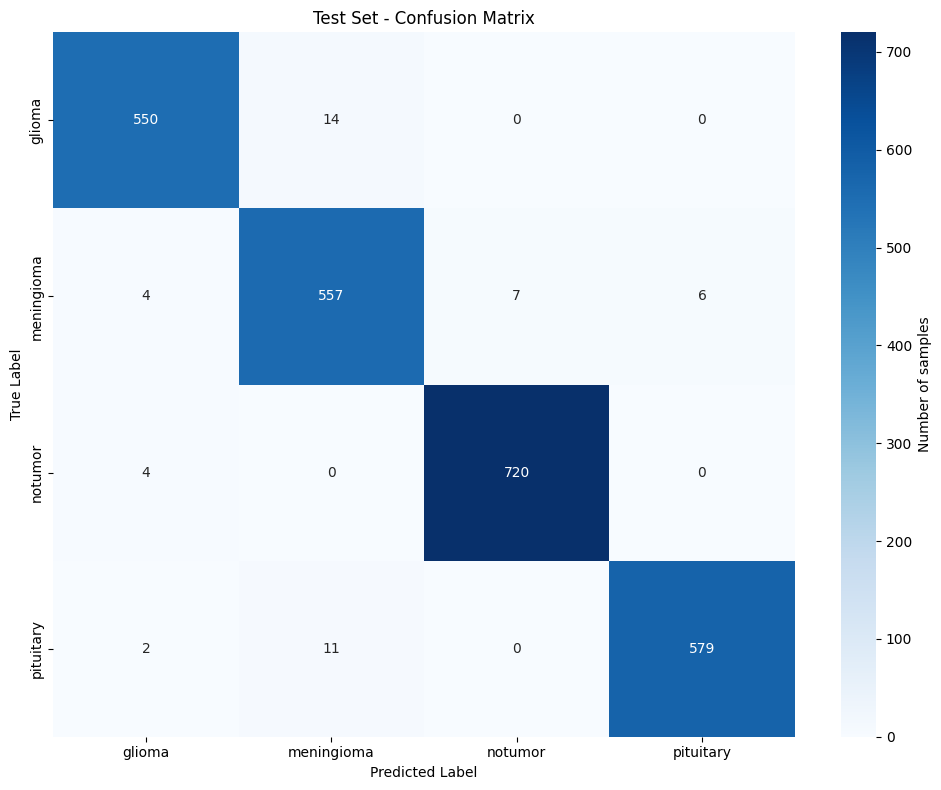


Test Set - Detailed Metrics:
     Class  Precision  Recall  F1-Score  Support
    glioma     0.9821  0.9752    0.9786      564
meningioma     0.9570  0.9704    0.9637      574
   notumor     0.9904  0.9945    0.9924      724
 pituitary     0.9897  0.9780    0.9839      592
   Overall     0.9805  0.9804    0.9805     2454

Files saved:
- Confusion matrix: ./plots/test_confusion_matrix.png
- Classification report: ./plots/test_classification_report.json
- Metrics CSV: ./plots/test_metrics.csv


In [8]:
# Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Evaluate on validation set
print("Evaluating on validation set...")
val_results = trainer.evaluate(eval_dataset=val_dataset)
print(f"Validation Results: {val_results}")

# Generate detailed classification report for validation set
val_report, val_cm, val_metrics = generate_classification_report(
    trainer, val_dataset, class_names, "Validation", PLOTS_DIR
)

# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")

# Generate detailed classification report for test set
test_report, test_cm, test_metrics = generate_classification_report(
    trainer, test_dataset, class_names, "Test", PLOTS_DIR
)

In [9]:
def create_comparison_plot(val_metrics, test_metrics, output_dir):
    """Create a comparison plot between validation and test metrics"""
    # Exclude 'Overall' row and 'Support' column for cleaner visualization
    val_data = val_metrics[val_metrics['Class'] != 'Overall'][['Class', 'Precision', 'Recall', 'F1-Score']]
    test_data = test_metrics[test_metrics['Class'] != 'Overall'][['Class', 'Precision', 'Recall', 'F1-Score']]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    metrics = ['Precision', 'Recall', 'F1-Score']
    x = np.arange(len(val_data['Class']))
    width = 0.35
    
    for i, metric in enumerate(metrics):
        axes[i].bar(x - width/2, val_data[metric], width, label='Validation', alpha=0.8, color='skyblue')
        axes[i].bar(x + width/2, test_data[metric], width, label='Test', alpha=0.8, color='lightcoral')
        
        axes[i].set_xlabel('Classes')
        axes[i].set_ylabel(metric)
        axes[i].set_title(f'{metric} Comparison: Validation vs Test')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(val_data['Class'], rotation=45)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(0, 1)
        
        # Add value labels on bars
        for j, (val_score, test_score) in enumerate(zip(val_data[metric], test_data[metric])):
            axes[i].text(j - width/2, val_score + 0.01, f'{val_score:.3f}', 
                        ha='center', va='bottom', fontsize=9)
            axes[i].text(j + width/2, test_score + 0.01, f'{test_score:.3f}', 
                        ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    comparison_path = os.path.join(output_dir, 'validation_vs_test_comparison.png')
    plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Comparison plot saved to: {comparison_path}")

Model saved to ./vit-brain-tumor-classifier


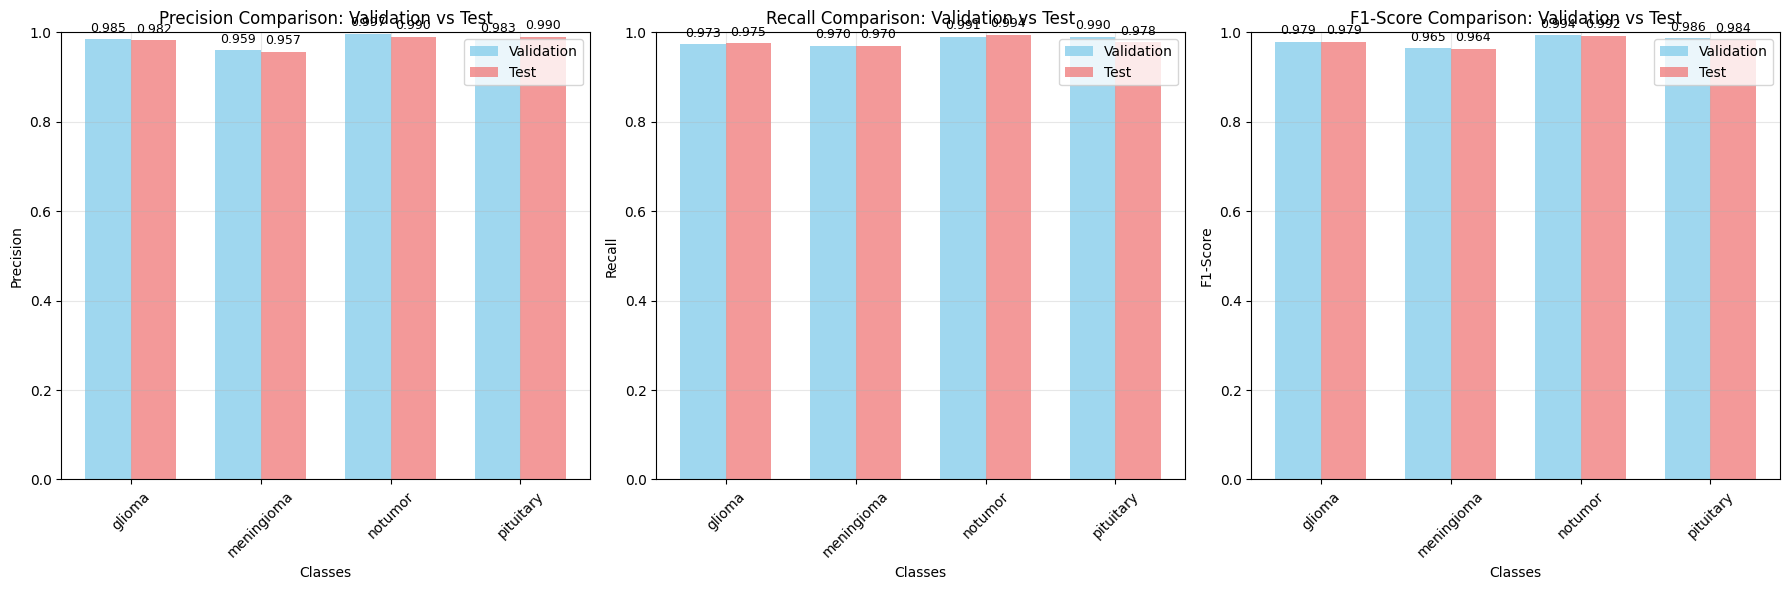

Comparison plot saved to: ./plots/validation_vs_test_comparison.png
Training completed successfully!

Final Results Summary:
Validation Accuracy: 0.9816
Test Accuracy: 0.9804


In [10]:
# Save the final model
trainer.save_model()
processor.save_pretrained(OUTPUT_DIR)

print(f"Model saved to {OUTPUT_DIR}")

# Save final results with classification reports
results_summary = {
    'validation_results': val_results,
    'test_results': test_results,
    'validation_classification_report': val_report,
    'test_classification_report': test_report,
    'data_splits': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset)
    }
}

with open(os.path.join(OUTPUT_DIR, 'results_summary.json'), 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)  # default=str to handle numpy arrays

# Create a summary comparison plot
create_comparison_plot(val_metrics, test_metrics, PLOTS_DIR)

print("Training completed successfully!")
print(f"\nFinal Results Summary:")
print(f"Validation Accuracy: {val_results['eval_accuracy']:.4f}")
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")

In [ ]:
# Function to make predictions on new images
def predict_image(model_path, image_path, processor_path=None):
    """
    Make prediction on a single image
    """
    if processor_path is None:
        processor_path = model_path
    
    # Load model and processor
    model = ViTForImageClassification.from_pretrained(model_path)
    processor = ViTImageProcessor.from_pretrained(processor_path)
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=1).item()
        confidence = predictions[0][predicted_class].item()
    
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    return {
        'predicted_class': classes[predicted_class],
        'confidence': confidence,
        'all_probabilities': {classes[i]: predictions[0][i].item() for i in range(len(classes))}
    }